In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


ModuleNotFoundError: No module named 'google.colab'

In [4]:
%cd /content/drive/Othercomputers/'My MacBook Pro'/GCode/WP_cryoEM
import numpy as np

/content/drive/Othercomputers/My MacBook Pro/GCode/WP_cryoEM


In [2]:
pts=np.load("maps/bunny.npy")
pts=pts[np.random.permutation(pts.shape[0]),:]

pts[:,0]=pts[:,0]-(pts[:,0].max()+pts[:,0].min())/2
pts[:,1]=pts[:,1]-(pts[:,1].max()+pts[:,1].min())/2
pts[:,2]=pts[:,2]-(pts[:,2].max()+pts[:,2].min())/2
pts_max=np.linalg.norm(pts,axis=1).max()
pts=pts/pts_max

pts_sub=pts[:200]

In [3]:
def rotation3d(d3_points,phi,psi,theta):
    r = R.from_euler('xyz', [phi, psi, theta], degrees=True)
    return r.apply(d3_points)
def inplane_distance_points(dataset,M=100):
    print('search one')
    N=dataset.shape[0]
    data2d=torch.tensor(dataset,dtype=torch.float32)


    theta=torch.arange(0,2*np.pi,2*np.pi/M)
    rot_matrix=torch.empty(M,2,2)
    rot_matrix[:,0,0]=torch.cos(theta)
    rot_matrix[:,0,1]=-torch.sin(theta)
    rot_matrix[:,1,0]=torch.sin(theta)
    rot_matrix[:,1,1]=torch.cos(theta)

    distance_matrix=torch.empty((N,N))
    angle_matrix=torch.empty((N,N))
    for i in tqdm(range(N)):
        pts2dI=data2d[i,:,:]
        pts2dI_bt=torch.broadcast_to(pts2dI,(data2d.shape[0],M,data2d.shape[1],data2d.shape[2]))
        pts2d_rot=torch.einsum('nzp,mpq->nmzq', data2d, rot_matrix)
        diff=torch.norm(pts2d_rot-pts2dI_bt,dim=(2,3))
        diff,min_index=torch.min(diff,dim=1)
        distance_matrix[i,:]=diff
        angle_matrix[i]=theta[min_index]
    return distance_matrix.numpy(),angle_matrix.numpy()


def get_img(d3_points,resolution=50,xlim=[-1,1],ylim=[-1,1],theta=None,block=False):
    [xlim_l,xlim_u]=xlim
    [ylim_l,ylim_u]=ylim
    devx=(xlim_u-xlim_l)/resolution
    devy=(ylim_u-ylim_l)/resolution
    data_2d=d3_points[:,:2]
    if theta is not None:
        rot_matrix=np.empty((2,2))
        rot_matrix[0,0]=np.cos(theta)
        rot_matrix[0,1]=-np.sin(theta)
        rot_matrix[1,0]=np.sin(theta)
        rot_matrix[1,1]=np.cos(theta)
        data_2d=data_2d@rot_matrix
    data_2d=data_2d.T


    xcord=(data_2d[0,:]-(xlim_l))/devx
    ycord=(data_2d[1,:]-(ylim_l))/devy


    xcord[xcord>=resolution]=resolution-1
    xcord[ycord>=resolution]=resolution-1
    xcord[xcord<0]=0
    ycord[ycord<0]=0


    xcord=torch.tensor(xcord,dtype=torch.long)
    ycord=torch.tensor(ycord,dtype=torch.long)
    z=torch.ones_like(xcord,dtype=torch.int)
    img=torch.zeros((resolution,resolution),dtype=torch.int)
    img.index_put_((xcord, ycord), z, accumulate=True)
    img=img.numpy()
    if block:
        img[img>0]=1
    return img

In [4]:
def get_img_3d(d3_points,resolution=50,xlim=[-1,1],ylim=[-1,1],zlim=[-1,1],theta=None,block=False):
    [xlim_l,xlim_u]=xlim
    [ylim_l,ylim_u]=ylim
    [zlim_l,zlim_u]=zlim
    devx=(xlim_u-xlim_l)/resolution
    devy=(ylim_u-ylim_l)/resolution
    devz=(ylim_u-ylim_l)/resolution
    data_3d=d3_points.T



    xcord=(data_3d[0,:]-(xlim_l))/devx
    ycord=(data_3d[1,:]-(ylim_l))/devy
    zcord=(data_3d[2,:]-(zlim_l))/devz



    xcord[xcord>=resolution]=resolution-1
    xcord[ycord>=resolution]=resolution-1
    zcord[zcord>=resolution]=resolution-1
    xcord[xcord<0]=0
    ycord[ycord<0]=0
    zcord[zcord<0]=0


    xcord=torch.tensor(xcord,dtype=torch.long)
    ycord=torch.tensor(ycord,dtype=torch.long)
    zcord=torch.tensor(zcord,dtype=torch.long)
    z=torch.ones_like(xcord,dtype=torch.int)
    img=torch.zeros((resolution,resolution,resolution),dtype=torch.int)
    img.index_put_((xcord, ycord,zcord), z, accumulate=True)
    img=img.numpy()
    if block:
        img[img>0]=1
    return img

In [5]:
resolution=50

In [10]:
V=get_img_3d(pts,resolution=resolution,block=True)
print(V.shape)
print(V.max())
print(V.min())
print(V.mean())

(50, 50, 50)
1
0
0.029984


In [7]:
plt.rcParams["figure.figsize"] = (12,8)

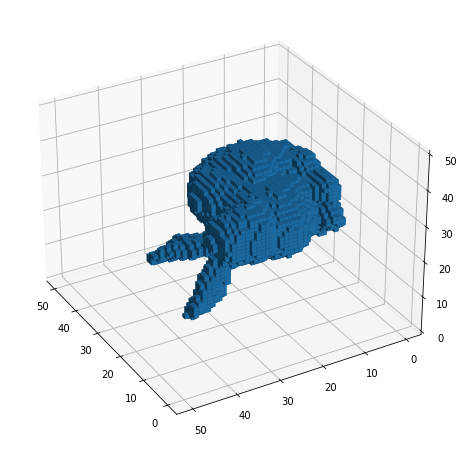

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(V)
ax.view_init(30, 150)
plt.show()

In [1]:
from tqdm import tqdm
#from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
#import torch.nn.functional as F
import networkx as nx
import torch
from skimage.data import shepp_logan_phantom
from skimage.transform import  rescale, radon, iradon
from skimage.morphology import disk
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import numpy as np
#from FBB import FBBasis2D
from scipy import sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import sys

sys.path.insert(0, '..')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import sys

sys.path.insert(0, '..')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

In [15]:
!pip -q install icosphere


In [12]:
#icosphere
from icosphere import icosphere
nu = 10  # or any other integer
vertices, faces = icosphere(nu)
print(vertices.shape[0])
data_number=vertices.shape[0]
rotation_list=[]
pts_list=[]
pts_sub_list=[]
ax1,ax2,ax3=vertices[:,0],vertices[:,1],vertices[:,2]
theta=0
r=np.sqrt(ax1**2+ax2**2)+1e-16
psi_list=np.arctan(ax3/r)/np.pi*180
phi_list=np.arctan2(ax2,ax1)/np.pi*180
for i in range(data_number):
    phi, psi=phi_list[i],psi_list[i]
    rotation_list.append(np.array([phi,psi,theta]))
    pts_list.append(rotation3d(pts,phi,psi,theta))
    pts_sub_list.append(rotation3d(pts_sub,phi,psi,theta))
rotation_list=np.array(rotation_list)
pts_list=np.array(pts_list)
pts_sub_list=np.array(pts_sub_list)

1002


In [13]:
data_angle=rotation_list/180*np.pi
ax1=np.cos(data_angle[:,1])*np.cos(data_angle[:,0])
ax2=np.cos(data_angle[:,1])*np.sin(data_angle[:,0])
ax3=np.sin(data_angle[:,1])

ax1,ax2,ax3=-ax3,ax2,ax1

In [14]:
resolution=50

In [15]:
dataset_image=[]
for i in tqdm(range(data_number)):
    dataset_image.append(get_img(pts_list[i,:,:],resolution=resolution))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:00<00:00, 4472.16it/s]


In [16]:
dataset_image=np.array(dataset_image)

In [20]:
def add_noise(SNR,sinogram):
    sinogram=np.array(sinogram)
    VARIANCE=(np.std(sinogram)**2)/(10**(SNR/10))
    #print(np.sqrt(VARIANCE))
    noise = np.random.randn(sinogram.shape[0],sinogram.shape[1],sinogram.shape[2])*np.sqrt(VARIANCE)
    return sinogram + noise
dataset_image=add_noise(0,dataset_image)

In [493]:
np.save('dataset_image.npy',dataset_image)


In [57]:
#rotation_list_re=np.load('rotation_list_re.npy')
rotation_list_re = rotation_list
print(rotation_list)

[[ 90.          58.28252559   0.        ]
 [-90.          58.28252559   0.        ]
 [ 58.28252559   0.           0.        ]
 ...
 [156.67133284 -42.94614726   0.        ]
 [163.64182431 -38.54830248   0.        ]
 [169.36652003 -34.13348103   0.        ]]


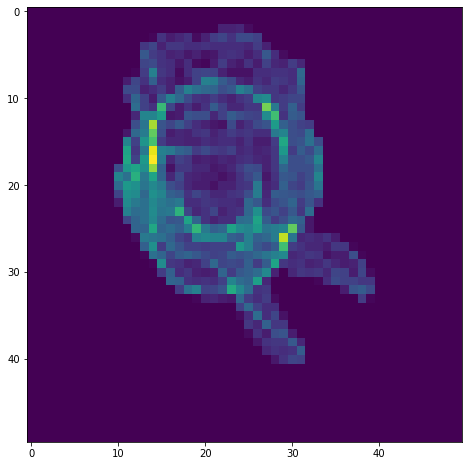

In [18]:
plt.imshow(dataset_image[0])

In [19]:
x3,y3,z3=np.indices((resolution,resolution,resolution))
x3,y3,z3=x3-resolution/2,y3-resolution/2,z3-resolution/2
mask3d=(x3**2+y3**2+z3**2)<(resolution/2)**2

x2,y2=np.indices((resolution,resolution))
x2,y2=x2-resolution/2,y2-resolution/2
r=((resolution/2)**2-x2**2-y2**2)
r[r<1]=1
r=np.sqrt(r)
r=r/r.max()*2

In [27]:
from scipy.ndimage.interpolation import rotate
def rotate_volume(V, alpha, beta, gamma):

    V = rotate(V, alpha, mode='constant', cval=0, order=3, axes=(2, 1), reshape=False)
    #V = rotate(V, alpha, mode='constant', cval=0, order=3, axes=(1, 0), reshape=False)
    V = rotate(V, beta, mode='constant', cval=0, order=3, axes=(2, 0), reshape=False)
    V = rotate(V, gamma, mode='constant', cval=0, order=3, axes=(1,0), reshape=False)
    return V

In [56]:
V=np.zeros((resolution,resolution,resolution),dtype=np.float)
for i in tqdm(range(data_number)):
    image=dataset_image[i]
    #V0=np.broadcast_to(image*r,(resolution,resolution,resolution)).transpose((1,2,0))
    V0=np.broadcast_to(image/r,(resolution,resolution,resolution)).transpose((1,2,0))
    V0=np.array(V0)
    V0=np.array(V0)
    V0[mask3d==False]=0
    
    rotations=rotation_list_re[i]
    V=V+rotate_volume(V0,rotations[0],rotations[1],rotations[2])
V=V/data_number


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:57<00:00, 17.57it/s]


In [29]:
V[mask3d==False]=0

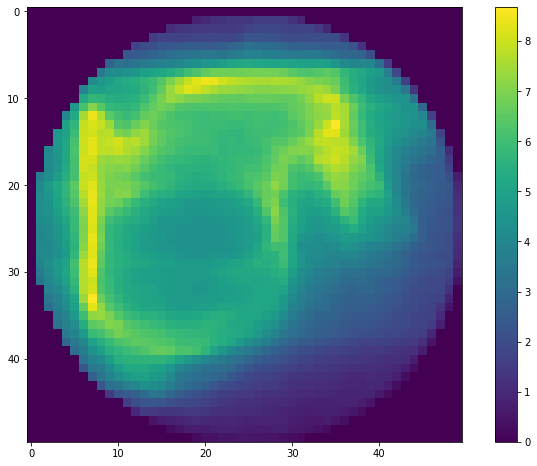

In [55]:
V=V
plt.imshow(V[:,:,25])
plt.colorbar()

In [54]:
Vx=V.copy()
Vx[Vx<6]=0

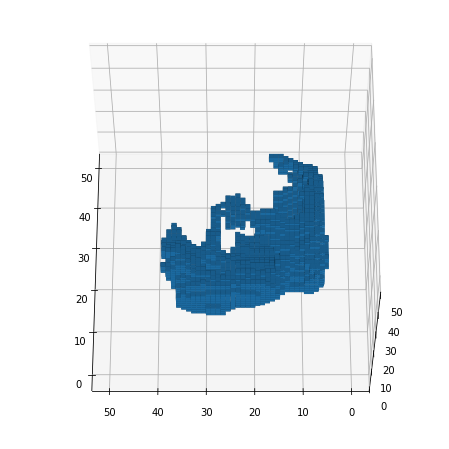

In [53]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(Vx)
ax.view_init(60, 180)
plt.show()

In [33]:
V1=V

In [34]:
V=V1

In [35]:
V[V<0.5]=0

In [36]:
color[:,3]

NameError: name 'color' is not defined

In [37]:
plt.plot(c/c.max())

NameError: name 'c' is not defined

In [473]:
thred=12
mask=V>thred
x3,y3,z3=np.indices((resolution,resolution,resolution))
xlong=(x3[mask]).reshape(-1)
ylong=y3[mask].reshape(-1)
zlong=z3[mask].reshape(-1)
c=V[mask]-thred
c=c**2
color=np.empty([len(c)] + [4], dtype=np.float32)
color[:,0]=0
color[:,1]=0
color[:,2]=0
color[:,3]=c/c.max()


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=xlong,
    y=ylong,
    z=zlong,
    mode='markers',
    marker=dict(
        size=5,               # set color to an array/list of desired values
        color=color
    )
))



fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=False)
fig.show()

In [276]:
mask.shape

(30921,)

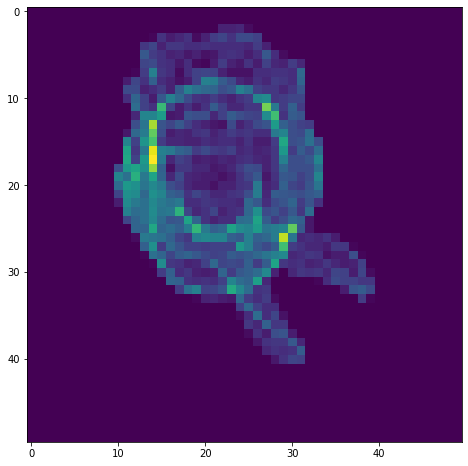

In [155]:
|plt.imshow(image)

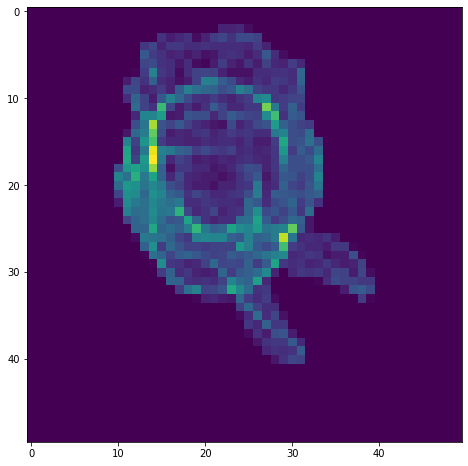

In [157]:
plt.imshow(V0[:,:,20])

In [38]:
V0[:,:,20].sum()

16430.397743913305

In [112]:
image.sum()

0

In [15]:
50*50*50*1000

125000000

In [39]:
from scipy.ndimage.interpolation import rotate
def rotate_volume(V,alpha,beta,gamma):
    V = rotate(V, alpha, mode='constant', cval=0, order=3, axes=(2, 1), reshape=False)
    V = rotate(V, beta, mode='constant', cval=0, order=3, axes=(2, 0), reshape=False)
    V = rotate(V, gamma, mode='constant', cval=0, order=3, axes=(1,0), reshape=False)
    return V

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(V)
ax.view_init(30, 150)
plt.show()

In [ ]:
V

In [84]:
V1=rotate_volume(V,0,0,90)

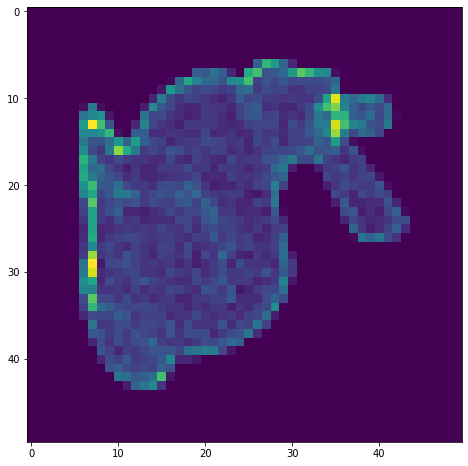

In [89]:
plt.imshow(V.sum(axis=2))

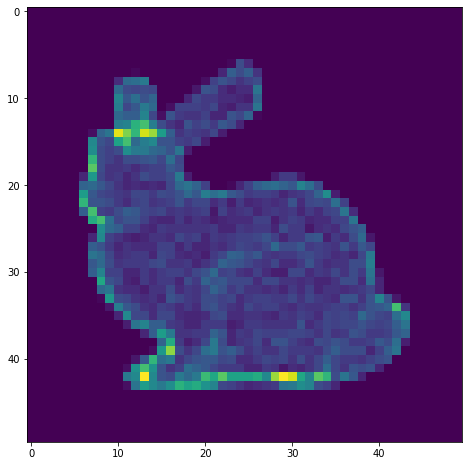

In [90]:
plt.imshow(V1.sum(axis=2))

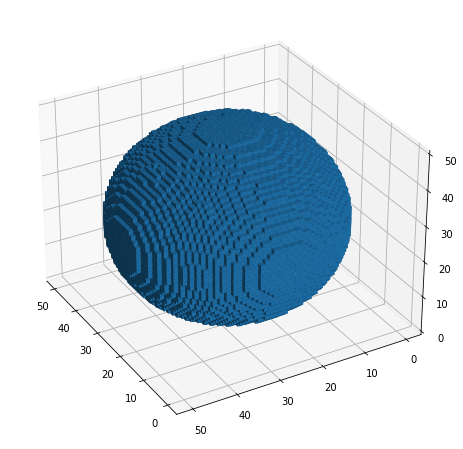

In [40]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(V1)
ax.view_init(30, 150)
plt.show()

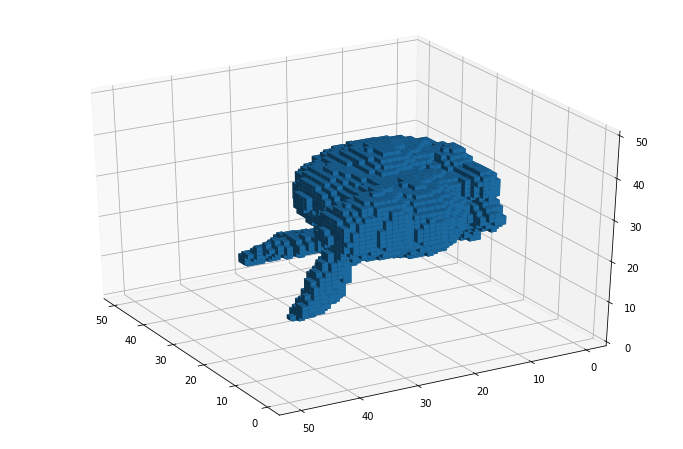

In [86]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(V)
ax.view_init(30, 150)
plt.show()

In [348]:
import sys
import numpy as np
from src.aspire.basis import ffb_2d

In [21]:

# Compute Graph Laplacian
def generateNeigbourHoodGraph(distanceMatrix, K,sym=True):
    samples = distanceMatrix.shape[0]
    neighbourMatrix = np.zeros_like(distanceMatrix)
    for i in range(samples):
        distanceRow = distanceMatrix[i, :]
        index = np.argsort(distanceRow)
        neighbourMatrix[i, index[:K+1]] = 1
        if sym:
            neighbourMatrix = (((neighbourMatrix + neighbourMatrix.T)>0)*1).astype('float64')
    return neighbourMatrix
"""
Compute the K-Nearest Neighbour distance matrix.
Computation is based on FFT, thus the number of angles evaluated is equal to the number of 
coefficients in the Fourier-Besel basis.
This is based on the Fast Fourier-Besel decomposition from aspire.
​
INPUT:
 - x1: shape (batch,N,N), set of input 2D-projections
 - K: number of neighbors
 - ell_max: cf aspire documention, leave it to None if you don't know what it means
​
 OUTPUT:
  - idx_best_img_knn: indeces of the K-NN best projections
  - angle_est_knn: angles of the K-NN best projections
"""
def rotation_invariant_knn(x1,K=10,ell_max=None):
    fb = ffb_2d.FFBBasis2D((x1.shape[1],x1.shape[1]),ell_max=ell_max,dtype=np.float64)
    c1 = fb.evaluate_t(x1)
    c1=fb.to_complex(c1)
    c1_normalized = c1/np.linalg.norm(c1,axis=1,keepdims=True)
    # Compute the K closest points for each image
    angle_est_knn = np.zeros((x1.shape[0],K))
    idx_best_img_knn = np.zeros((x1.shape[0],K),dtype=int)
    dist_knn = np.zeros((x1.shape[0],K))
    for l in range(x1.shape[0]):
        c_crt = c1_normalized[l][None]
        # Compute correlation on FB basis 
        gamma = np.zeros((c1_normalized.shape[0],len(np.unique(fb.complex_angular_indices ))),dtype=complex)
        for kk in np.unique(fb.complex_angular_indices ):
            gamma[:,kk] = (c1_normalized[:,fb.complex_angular_indices ==kk]*np.conj(c_crt[:,fb.complex_angular_indices ==kk])).sum(1)
        corr = np.abs(np.fft.fft(gamma))
        
        ## Get the best angle for every image
        corr_max_ = np.max(corr,axis=1)
        idx_angle_max_ = np.argmax(corr,axis=1)
        ## Find K images that have the highest correlation
        # avoid sorting the full array
        idx_img = np.argpartition(-corr_max_, K+1,axis=0)[:K+1]
        idx_img = idx_img[idx_img!=l]
        
        idx_best_img = idx_img[np.argsort(corr_max_[idx_img])[::-1]] # indices of the best match of images
        idx_angle_max = idx_angle_max_[idx_best_img] # indices of the angles corresponding to bets images
        corr_max = corr_max_[idx_best_img] # value of the correlation of the best images
        angle_est = 2*np.pi*idx_angle_max/corr.shape[1] # angle corresponding the the best matches in radian
        idx_best_img_knn[l] = idx_best_img
        angle_est_knn[l] = angle_est
        dist_knn[l] = 1-corr_max
    return dist_knn, idx_best_img_knn, angle_est_knn
"""
Compute the K-Nearest Neighbour distance matrix. 
Warning, unless the previous function, this function store the full distance matrix.
This will work only if enough RAM is available.
This function rests on the same implementation as the previous one, but avoid the for loop over all the projections.
​
Computation is based on FFT, thus the number of angles evaluated is equal to the number of 
coefficients in the Fourier-Besel basis.
This is based on the Fast Fourier-Besel decomposition from aspire.
​
INPUT:
 - x1: shape (batch,N,N), set of input 2D-projections
 - K: number of neighbors
 - ell_max: cf aspire documention, leave it to None if you don't know what it means
​
 OUTPUT:
  - idx_best_img_knn: indeces of the K-NN best projections
  - angle_est_knn: angles of the K-NN best projections
"""
def rotation_invariant_knn_full(x1,K=10,ell_max=None):
    fb = ffb_2d.FFBBasis2D((x1.shape[1],x1.shape[1]),ell_max=ell_max,dtype=np.float64)
    c1 = fb.evaluate_t(x1)
    c1=fb.to_complex(c1)
    c1_normalized = c1/np.linalg.norm(c1,axis=1,keepdims=True)
    gamma = np.zeros((c1_normalized.shape[0],c1_normalized.shape[0],len(np.unique(fb.complex_angular_indices ))),dtype=complex)
    for kk in np.unique(fb.complex_angular_indices ):
        tmp = c1_normalized[:,fb.complex_angular_indices ==kk]
        gamma[:,:,kk] = (np.conj(tmp[:,None,:])*tmp[None,:,:]).sum(2)
    corr = np.abs(np.fft.fft(gamma))
    ## Get the best angle for every image
    corr_max_ = np.max(corr,axis=-1)
    idx_angle_max_ = np.argmax(corr,axis=-1)
    
    from sklearn.neighbors import NearestNeighbors
    knn_distance_based = NearestNeighbors(n_neighbors=K, metric="precomputed").fit(1-corr_max_)
    dist_knn, idx_best_img_knn = knn_distance_based.kneighbors(return_distance=True)
    angle_est = 2*np.pi*idx_angle_max_/corr.shape[-1]
    angle_est = np.array([angle_est[np.arange(idx_best_img_knn.shape[0]),idx_best_img_knn[:,k]] for k in range(K)]).T
    return dist_knn, idx_best_img_knn, angle_est

In [360]:
dist_knn, idx_best_img_knn, angle_est_knn=rotation_invariant_knn(np.array(dataset_image,dtype=np.float64))

2022-01-24 23:13:34,303 INFO Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2022-01-24 23:13:34,633 WARNING FFBBasis2D::evaluate_t passed numpy array instead of Image.


In [367]:
idx_best_img_knn.shape

(1002, 10)

In [371]:
A=np.zeros((data_number,data_number))

In [372]:
for i in range(resolution):
    A[i,idx_best_img_knn[i]]=1

In [370]:
idx_best_img_knn[i]

array([ 30,  12,  21,  48, 354,  39,  31, 318, 282, 426])

In [ ]:
plot_Laplacian()

In [22]:

def plot_Laplacian(dataset,n_neighbors = 10,is_X=False,data_label=None,plot_line=False,A=None,use_A=False):
    color_RGBA=data_label
    if not use_A:
        if is_X==False:
            data=dataset.reshape(dataset.shape[0],-1)
            A_nl= kneighbors_graph(data, n_neighbors=n_neighbors).toarray()
        else:
            data=dataset.reshape(dataset.shape[0],-1)
            A_nl=neighbotFromX(data,n_neighbors=n_neighbors)
    else:
        A_nl=A
    # A_k=sparse.csr_matrix(A_nl)
    # A_knn = 0.5*(A_k + sparse.csr_matrix.transpose(A_k))
    # L = sparse.csr_matrix(sparse.diags(np.ones(A_nl.shape[0]))) - A_knn
    A_knn=0.5*(A_nl+A_nl.T)
    A_knn[A_knn>1]=1
    D=np.diag(A_knn.sum(axis=1))
    L = np.diag(A_knn.sum(axis=1)) - A_knn
    # D_invdiv2=np.diag(np.sqrt(1/A_knn.sum(axis=1)))
    # L=np.eye(A_knn.shape[0])-D_invdiv2@A_knn@D_invdiv2
    L=sparse.csr_matrix(L)
    eigenValues, eigenVectors=eigsh(L,k=4,which='SM')
    idx = np.argsort(eigenValues)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=eigenVectors[:, idx[1]],
        y=eigenVectors[:, idx[2]],
        z=eigenVectors[:, idx[3]],
        mode='markers',
        marker=dict(
            size=5,               # set color to an array/list of desired values
            color=color_RGBA
        )
    ))

    # tight layout
    if plot_line:
        N=A_knn.shape[0]
        for i in tqdm(range(N)):
            xi=eigenVectors[i, idx[1]]
            yi=eigenVectors[i, idx[2]]
            zi=eigenVectors[i, idx[3]]
            for j in range(N):
                if A_knn[i][j]>0:
                    xj=eigenVectors[j, idx[1]]
                    yj=eigenVectors[j, idx[2]]
                    zj=eigenVectors[j, idx[3]]
                    fig.add_trace(go.Scatter3d(x=[xi,xj],y=[yi,yj],z=[zi,zj],mode='lines',line=dict(width=2,color=(color_RGBA[i]+color_RGBA[j])/2)))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=False)
    fig.show()

In [376]:
A_knn=0.5*(A+A.T)
A_knn[A_knn>1]=1
D=np.diag(A_knn.sum(axis=1))
L = np.diag(A_knn.sum(axis=1)) - A_knn
# D_invdiv2=np.diag(np.sqrt(1/A_knn.sum(axis=1)))
# L=np.eye(A_knn.shape[0])-D_invdiv2@A_knn@D_invdiv2
L=sparse.csr_matrix(L)
eigenValues, eigenVectors=eigsh(L,k=4,which='SM')
idx = np.argsort(eigenValues)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=eigenVectors[:, idx[1]],
    y=eigenVectors[:, idx[2]],
    z=eigenVectors[:, idx[3]],
    mode='markers',
    marker=dict(
        size=5               # set color to an array/list of desired values

    )
))
